In [1]:
pip install --upgrade google-cloud-bigquery


     |████████████████████████████████| 163kB 5.1MB/s 
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.14.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: six 1.12.0
    Uninstalling six-1.12.0:
      Successfully uninstalled six-1.12.0
  Found existing installation: google-cloud-bigquery 1.21.0
    Uninstalling google-cloud-bigquery-1.21.0:
      Successfully uninstalled google-cloud-bigquery-1.21.0


In [128]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'capstone-247602'
client = bigquery.Client(project=project_id)

for dataset in client.list_datasets():
  print(dataset.dataset_id)

import pandas as pd

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'capstone-247602'
df_full = pd.io.gbq.read_gbq('''
SELECT * FROM `capstone-247602.combined_digital_linear.tbl_title_matching_stage_3_FINAL`''', 
project_id=project_id, verbose=False)

Digital_Data
Nielsen_Data
combined_digital_linear
predictions


In [0]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [177]:
# Filter main dataframe by SHOW
# Add in calculated features
# Make airdate the index
# create dataframe of features for Average Mins Viewed and Imps

import warnings
warnings.filterwarnings("ignore")

#show_name = "SUPERSTORE"
#show_table = df_full[df_full.Show_Name == show_name]

show_table = df_full
show_table['days_since_last_episode'] = (show_table.groupby('Season')['airdate'].diff().fillna(0).astype(str).str[:2]).astype(str).astype(int)
show_table['days_since_1st_episode'] = ((show_table.airdate - show_table.airdate.min()).astype(str).str[:2]).astype(str).astype(int)


show_table['airdate']= pd.to_datetime(show_table['airdate']) 
show_table = show_table.set_index('airdate')


df_amv = show_table[[ 'average_mins_viewed','days_since_last_episode','days_since_1st_episode','dummy_weekday','dummy_10pm','dummy_9pm','dummy_8pm',
                 'quarter','Median_Age','Median_Income','season_number','Season','episode_number']]

df_I = show_table[[ 'Imps','days_since_last_episode','days_since_1st_episode','dummy_weekday','dummy_10pm','dummy_9pm','dummy_8pm',
                 'quarter','Median_Age','Median_Income','season_number','Season','episode_number']]

print(len(df_amv),len(df_I))
df_amv.head()

2954 2954


,average_mins_viewed,days_since_last_episode,days_since_1st_episode,dummy_weekday,dummy_10pm,dummy_9pm,dummy_8pm,quarter,Median_Age,Median_Income,season_number,Season,episode_number
airdate,,,,,,,,,,,,,
2018-03-13,1.499507e+06,0,15,1,1,0,0,1,57,72400,1,2017,1
2018-03-20,1.060909e+06,7,15,1,0,1,0,1,57,68200,1,2017,2
2018-03-27,8.688466e+05,7,15,1,0,1,0,1,58,69600,1,2017,3
2018-04-03,7.841327e+05,7,15,1,0,1,0,2,57,66500,1,2017,4
2018-04-10,7.292799e+05,7,15,1,0,1,0,2,57,67200,1,2017,5


In [0]:
# SINGLE VARIANT TENSORFLOW

In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [0]:
df = show_table[[ 'average_mins_viewed']]

In [0]:
TRAIN_SPLIT = int(len(df)*.7)
tf.compat.v1.set_random_seed(13)

In [180]:
uni_data = df['average_mins_viewed']
uni_data.head()

airdate
2018-03-13    1.499507e+06
2018-03-20    1.060909e+06
2018-03-27    8.688466e+05
2018-04-03    7.841327e+05
2018-04-10    7.292799e+05
Name: average_mins_viewed, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdcdac9cf98>],
      dtype=object)

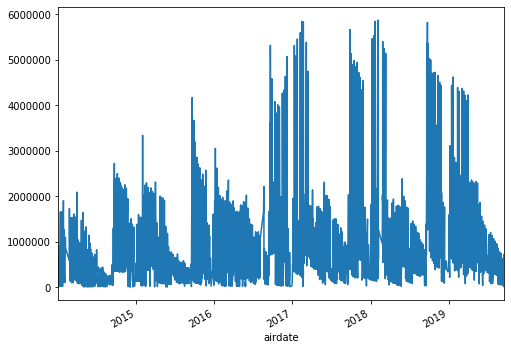

In [181]:
uni_data.plot(subplots=True)

In [0]:
uni_data = uni_data.values

In [0]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [0]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [185]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target Average Mins Viewed')
print (y_train_uni[0])

Single window of past history
[[ 0.53807362]
 [ 0.036717  ]
 [-0.18282743]
 [-0.2796631 ]
 [-0.34236474]
 [-0.40127155]
 [-0.46254722]
 [-0.48652937]
 [-0.5168843 ]
 [-0.53962955]
 [-0.48580007]
 [-0.70474665]
 [-0.75583872]
 [-0.30155333]
 [-0.29133484]
 [-0.38879607]
 [-0.45303141]
 [-0.38861598]
 [-0.30474974]
 [-0.66687273]]

 Target Average Mins Viewed
-0.7945591591111739


In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

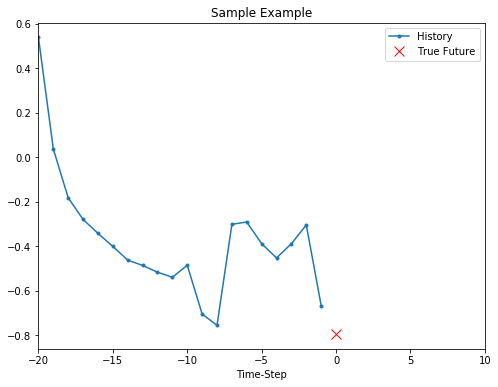

In [188]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [0]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

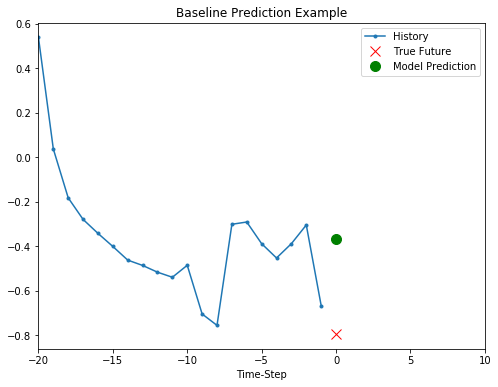

In [190]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [0]:
'''
Recurrent neural network
A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. 
RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. 
For more details, read the RNN tutorial. In this tutorial, you will use a specialized RNN layer called Long Short Term Memory (LSTM)

Let's now use tf.data to shuffle, batch, and cache the dataset.
'''
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [0]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [193]:

for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [194]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 4s 20ms/step - loss: 0.4184 - val_loss: 0.2030
Epoch 2/10
200/200 [==============================] - 2s 12ms/step - loss: 0.2549 - val_loss: 0.1418
Epoch 3/10
200/200 [==============================] - 2s 12ms/step - loss: 0.2030 - val_loss: 0.1338
Epoch 4/10
200/200 [==============================] - 2s 12ms/step - loss: 0.1852 - val_loss: 0.1323
Epoch 5/10
200/200 [==============================] - 2s 12ms/step - loss: 0.1721 - val_loss: 0.1304
Epoch 6/10
200/200 [==============================] - 2s 12ms/step - loss: 0.1665 - val_loss: 0.1303
Epoch 7/10
200/200 [==============================] - 2s 11ms/step - loss: 0.1644 - val_loss: 0.1294
Epoch 8/10
200/200 [==============================] - 2s 12ms/step - loss: 0.1631 - val_loss: 0.1296
Epoch 9/10
200/200 [==============================] - 2s 12ms/step - loss: 0.1618 - val_loss: 0.1305
Epoch 10/10
200/200 [===========================

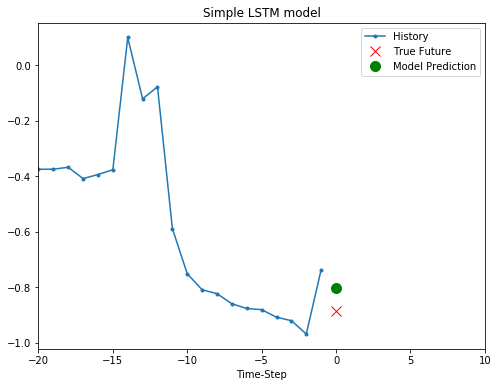

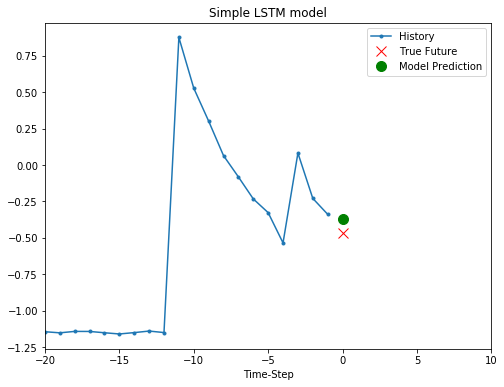

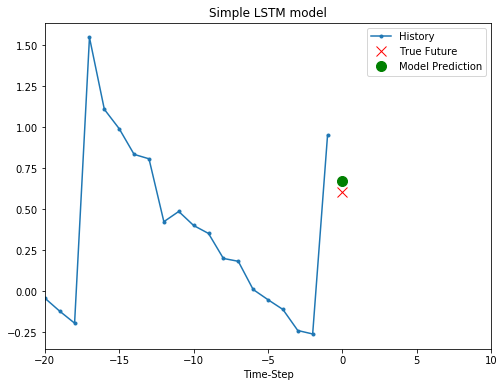

In [195]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

In [0]:
# Forecast a multivariate time series

In [0]:
features_considered = ['average_mins_viewed','days_since_last_episode','days_since_1st_episode','dummy_weekday','dummy_10pm','dummy_9pm','dummy_8pm',
                 'quarter','Median_Age','Median_Income','season_number','episode_number']

target_considered = ['average_mins_viewed']

In [197]:
features = df_amv[features_considered]
features.head()

,average_mins_viewed,days_since_last_episode,days_since_1st_episode,dummy_weekday,dummy_10pm,dummy_9pm,dummy_8pm,quarter,Median_Age,Median_Income,season_number,episode_number
airdate,,,,,,,,,,,,
2018-03-13,1.499507e+06,0,15,1,1,0,0,1,57,72400,1,1
2018-03-20,1.060909e+06,7,15,1,0,1,0,1,57,68200,1,2
2018-03-27,8.688466e+05,7,15,1,0,1,0,1,58,69600,1,3
2018-04-03,7.841327e+05,7,15,1,0,1,0,2,57,66500,1,4
2018-04-10,7.292799e+05,7,15,1,0,1,0,2,57,67200,1,5


In [199]:
print(len(features))

2954


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdcdb001ac8>,
      dtype=object)

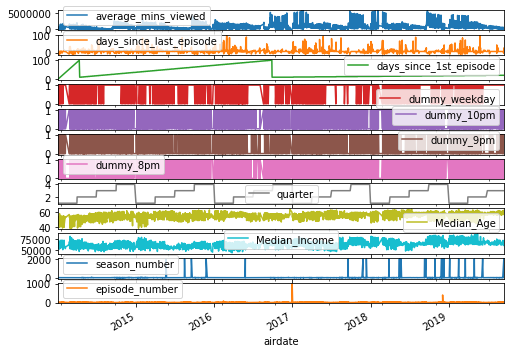

In [200]:
features.plot(subplots=True)

In [0]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [0]:
past_history = 30
future_target = 5
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 0], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 0],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [204]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (30, 12)


In [0]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [0]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [207]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [208]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 8s 39ms/step - loss: 0.3690 - val_loss: 0.4281
Epoch 2/10
200/200 [==============================] - 6s 32ms/step - loss: 0.2431 - val_loss: 0.5013
Epoch 3/10
200/200 [==============================] - 7s 33ms/step - loss: 0.2049 - val_loss: 0.5557
Epoch 4/10
200/200 [==============================] - 7s 33ms/step - loss: 0.1830 - val_loss: 0.6016
Epoch 5/10
200/200 [==============================] - 7s 33ms/step - loss: 0.1684 - val_loss: 0.6361
Epoch 6/10
200/200 [==============================] - 6s 32ms/step - loss: 0.1567 - val_loss: 0.6672
Epoch 7/10
200/200 [==============================] - 7s 33ms/step - loss: 0.1467 - val_loss: 0.6782
Epoch 8/10
200/200 [==============================] - 7s 33ms/step - loss: 0.1389 - val_loss: 0.6897
Epoch 9/10
200/200 [==============================] - 6s 31ms/step - loss: 0.1321 - val_loss: 0.7210
Epoch 10/10
200/200 [===========================

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

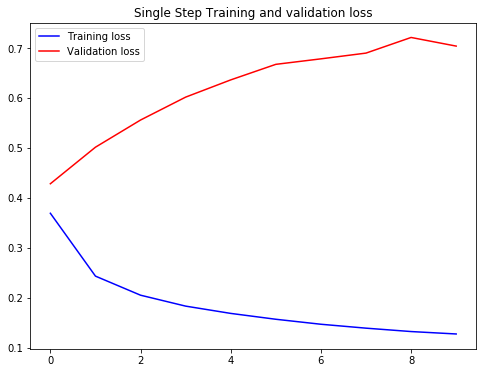

In [210]:
plot_train_history(single_step_history,'Single Step Training and validation loss')

In [0]:
#  Predict a single step future Now

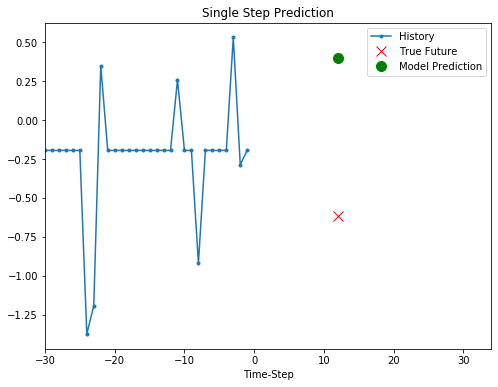

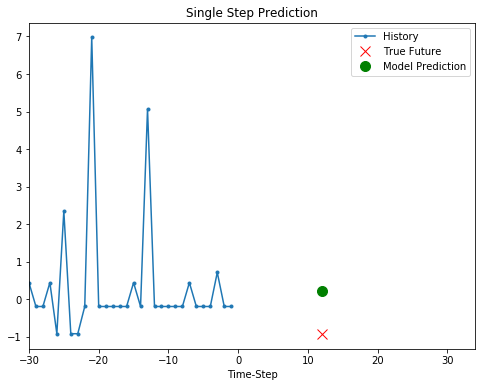

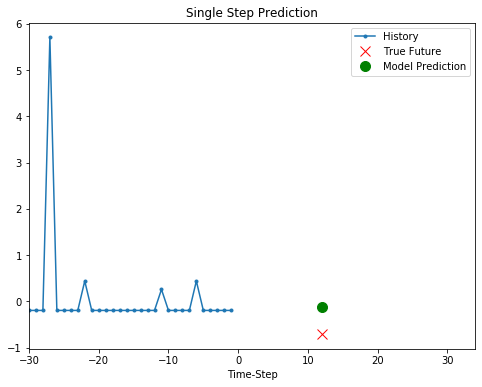

In [211]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

In [0]:
# Multi-Step model

In [0]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 0], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [213]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Average Mins Viewed to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (30, 12)

 Average Mins Viewed to predict : (72,)


In [0]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [0]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

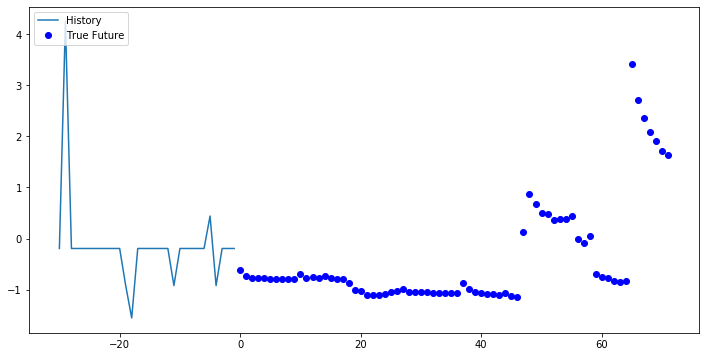

In [216]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [0]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [218]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 72)


In [219]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 13s 64ms/step - loss: 0.5166 - val_loss: 0.7030
Epoch 2/10
200/200 [==============================] - 10s 51ms/step - loss: 0.3980 - val_loss: 0.6966
Epoch 3/10
200/200 [==============================] - 11s 53ms/step - loss: 0.3557 - val_loss: 0.6673
Epoch 4/10
200/200 [==============================] - 11s 54ms/step - loss: 0.3305 - val_loss: 0.6948
Epoch 5/10
200/200 [==============================] - 10s 52ms/step - loss: 0.3142 - val_loss: 0.6829
Epoch 6/10
200/200 [==============================] - 10s 52ms/step - loss: 0.3031 - val_loss: 0.6771
Epoch 7/10
200/200 [==============================] - 10s 52ms/step - loss: 0.2936 - val_loss: 0.6932
Epoch 8/10
200/200 [==============================] - 10s 52ms/step - loss: 0.2830 - val_loss: 0.6796
Epoch 9/10
200/200 [==============================] - 10s 52ms/step - loss: 0.2742 - val_loss: 0.6766
Epoch 10/10
200/200 [==================

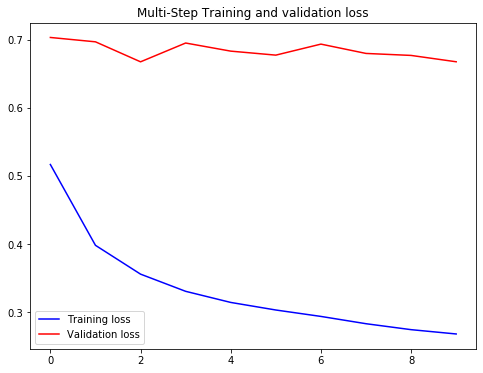

In [220]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

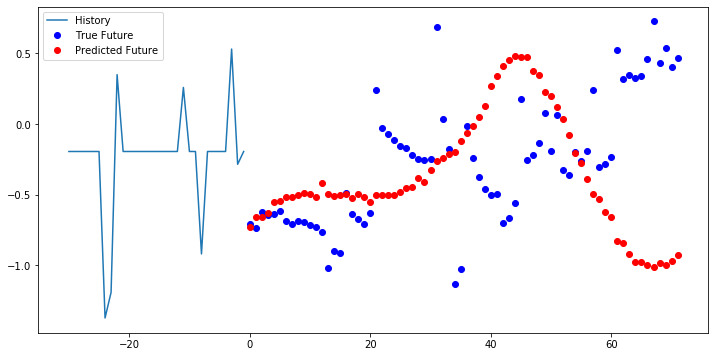

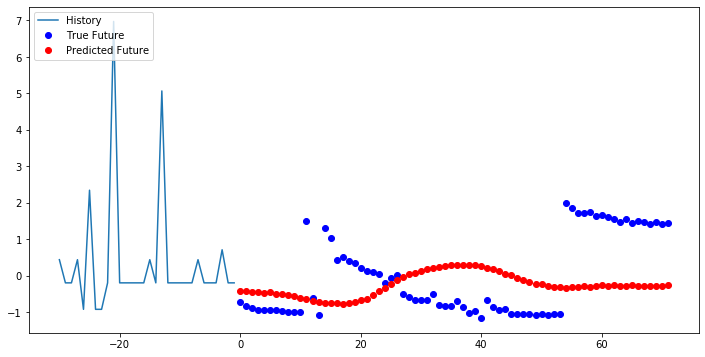

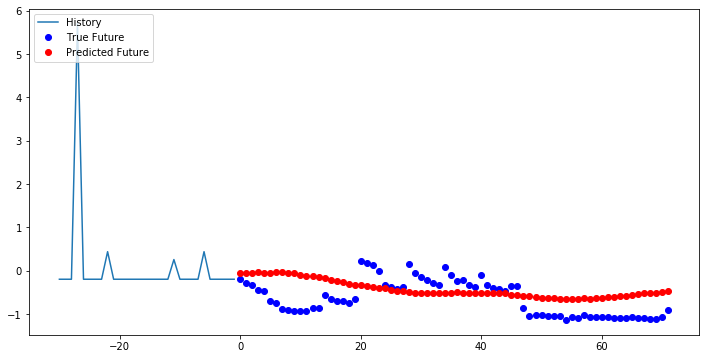

In [221]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])